In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 136MB/s]


VitGenerator(
  (model): ViT(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerEncoder(
        (attn): MultiHeadAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): MultiLayerPerceptron(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (gelu): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (head): Identity()
  )
)


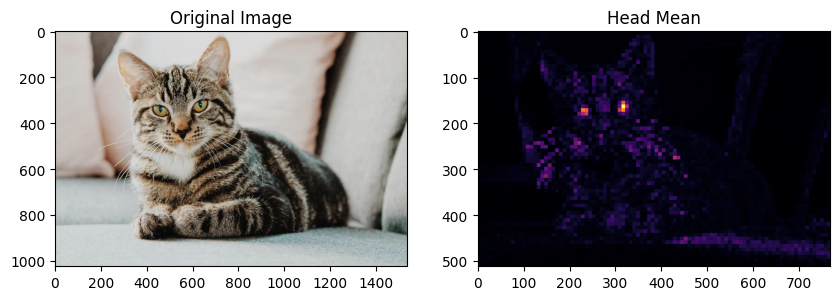

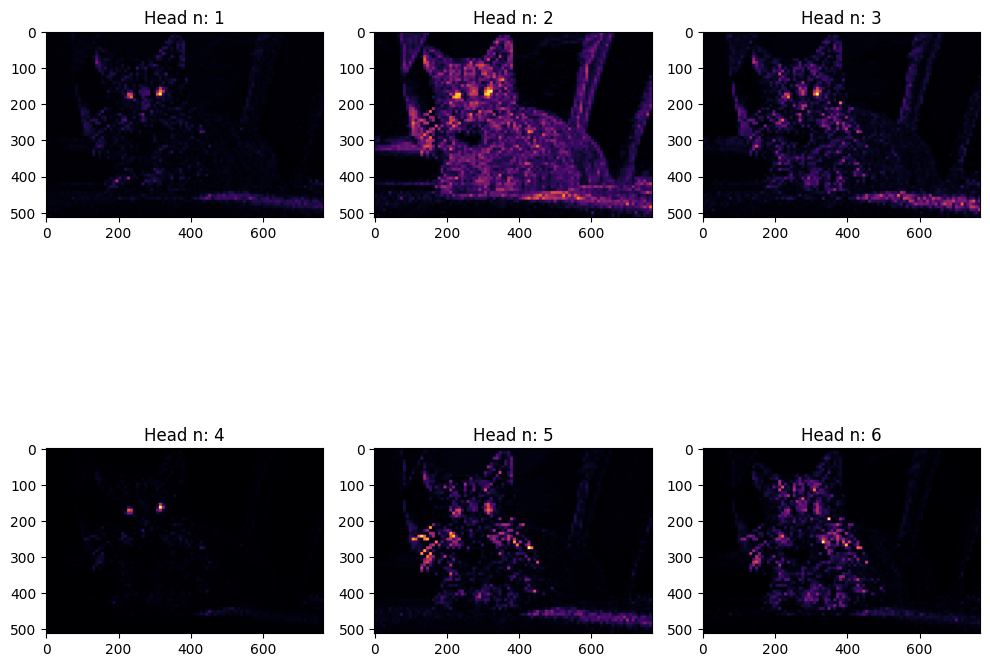

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from einops import rearrange, repeat
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import sys
sys.path.append('../')



class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=7, in_chans=3, embed_dim=49):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # b, embedding, n_patches_h, n_patches_w

    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b e n1 n2 -> b (n1 n2) e') # b, long, embedding
        return x


class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()

        # key, query, value projections

        self.qkv = nn.Linear(n_embd, n_embd * 3)
        self.n_heads = n_heads

        # output projection
        self.proj = nn.Linear(n_embd, n_embd)


    def forward(self, x):
        # B, L, F = x.size() # batch, length, features

        qkv = rearrange(self.qkv(x), 'b l (c h f) -> c b h l f', h=self.n_heads, c=3) # (B, H, L, F/H)
        q, k, v = qkv[0], qkv[1], qkv[2]

        scores = q @ k.transpose(-2,-1) / math.sqrt(k.size(-1)) # B, H, L, L
        att = F.softmax(scores, dim=-1)

        y = att @ v # B, H, L, F/H

        y = rearrange(y, 'b h l f -> b l (h f)')


        y = self.proj(y) # batch, length, feature

        return y, att


class MultiLayerPerceptron(nn.Module):
    def __init__(self, n_embd, mlp_ratio):
        super().__init__()

        hidden_features = int(n_embd * mlp_ratio)
        self.fc1 = nn.Linear(n_embd, hidden_features)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, n_embd)


    def forward(self,x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, n_embd, n_heads, mlp_ratio):
        super().__init__()

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.norm1 = torch.nn.LayerNorm(n_embd)
        self.norm2 = torch.nn.LayerNorm(n_embd)
        self.mlp = MultiLayerPerceptron(n_embd, mlp_ratio)

    def forward(self, x, return_attention=False):

        x1 = self.norm1(x) #layer normalization
        x1 = self.attn(x1) # multihead attention


        if return_attention:
            return x1[1]

        x = x + x1[0] # residual connection

        x2 = self.norm2(x) #layer normalization
        x2 = self.mlp(x2) # multilayer perceptron

        y = x + x2 # residual connection



        return y


class ViT(nn.Module):

    def __init__(self,img_dim= 224 , patch_dim=7, embed_dim=100, num_classes=0, n_heads=8, depth=2, mlp_ratio=.4):
        super().__init__()


        self.patch_embed = PatchEmbedding(patch_dim, 3, embed_dim)
        self.cls_token = nn.Parameter( torch.randn(1, 1, embed_dim))

        n_patches = (img_dim // patch_dim) ** 2
        self.pos_embed  = nn.Parameter( torch.randn(1, n_patches+1, embed_dim))

        self.blocks = nn.ModuleList([TransformerEncoder(embed_dim, n_heads, mlp_ratio) for _ in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()


    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(
                math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(
            w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        x = self.patch_embed(x) # (B, L, F)
        cls = repeat(self.cls_token, '1 1 f -> b 1 f', b=x.shape[0])
        x = torch.cat([cls, x], dim=1) # (B, L+1, F)

        return x

    def forward(self, x):

        e = self.prepare_tokens(x)

        e = e + self.interpolate_pos_encoding(e, x.shape[-2], x.shape[-1])

        z = self.transformer(e) # (B, L+1, F)

        cls_token = z[:, 0, :]  # (B, F)

        y = self.head(cls_token) # (B, num_classes)
        y = self.norm(y)

        return y

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)




class VitGenerator(nn.Module):
    def __init__(self,  name_model, patch_size, device, evaluate=True, verbose=False):
        super().__init__()
        self.name_model = name_model
        self.patch_size = patch_size
        self.device = device

        if self.name_model == 'vit_tiny':
            model = ViT(patch_dim=self.patch_size, embed_dim=192, depth=12, n_heads=3, mlp_ratio=4)

        elif self.name_model == 'vit_small':
            model = ViT(patch_dim=self.patch_size, embed_dim=384, depth=12, n_heads=6, mlp_ratio=4)

        elif self.name_model == 'vit_base':
            model = ViT(patch_dim=self.patch_size, embed_dim=768, depth=12, n_heads=12, mlp_ratio=4)
        else:
            raise f"No model found with {self.name_model}"

        self.model = model
        self.model.to(device)
        self._loadPretrainedWeights()


    def _loadPretrainedWeights(self):
        url = None
        if self.name_model == 'vit_small' and self.patch_size == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

        elif self.name_model == 'vit_small' and self.patch_size == 8:
            url = "dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"

        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        self.model.load_state_dict(state_dict, strict=True)


    def __call__(self, x):
        return self.model(x)


    def get_last_selfattention(self, img):
        return self.model.get_last_selfattention(img.to(self.device))



def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))


    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VitGenerator(name_model='vit_small', patch_size=8, device=device, evaluate=True, verbose=True)
print(model)


path = './gato.webp'
img = Image.open(path)
factor_reduce = 2
img_size = tuple(np.array(img.size[::-1]) // factor_reduce)
visualize_predict(model, img, img_size, 8, device)